# 🚀 Proyecto Final: Implementación de Machine Learning (Clasificación de Churn) - Refactorizado

**Objetivo:** Este notebook consolida las etapas de Ingeniería de Características (Feature Engineering) y la implementación técnica de un modelo de **Clasificación de Churn (Abandono de Clientes)**.

**Mejoras en esta versión:**
1.  **Modularidad:** Código organizado en funciones reutilizables.
2.  **Pipeline:** Uso de `sklearn.pipeline` para encapsular preprocesamiento y modelado.
3.  **Optimización:** Búsqueda de hiperparámetros con `GridSearchCV`.
4.  **Visualización:** Gráficos exploratorios y de evaluación con interpretaciones detalladas.
5.  **Persistencia:** Guardado del modelo final.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import sys
import joblib

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

# Configuración visual
plt.style.use('dark_background')
plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
})

## 1. Funciones de Carga y Preprocesamiento

In [2]:
def load_data(sales_path, customers_path):
    """
    Carga los datos de ventas y clientes, convirtiendo fechas al formato correcto.
    """
    try:
        df_sales = pd.read_csv(sales_path)
        df_sales['fecha'] = pd.to_datetime(df_sales['fecha'])
        df_sales['fecha_alta'] = pd.to_datetime(df_sales['fecha_alta'])
        print(f"✅ Ventas cargadas: {len(df_sales)} registros.")
    except FileNotFoundError:
        sys.exit(f"❌ Error: No se encontró {sales_path}")

    try:
        df_customers = pd.read_excel(customers_path)
        df_customers['fecha_alta'] = pd.to_datetime(df_customers['fecha_alta'])
        print(f"✅ Clientes cargados: {len(df_customers)} registros.")
    except FileNotFoundError:
        print(f"⚠️ Advertencia: No se encontró {customers_path}. Se usará solo info de ventas.")
        df_customers = None
        
    return df_sales, df_customers

def feature_engineering(df_sales, df_customers, churn_threshold=90):
    """
    Genera el dataset RFM+T y etiqueta el Churn.
    """
    # Fecha de referencia (día siguiente a la última venta)
    ref_date = df_sales['fecha'].max() + timedelta(days=1)
    print(f"📅 Fecha de corte: {ref_date.date()}")

    # Agregación por cliente (Activos)
    df_rfm = df_sales.groupby('id_cliente').agg({
        'fecha': lambda x: (ref_date - x.max()).days,      # Recencia
        'id_venta': 'nunique',                             # Frecuencia
        'importe': 'sum',                                  # Monetario
        'cantidad': 'sum',                                 # Total Artículos
        'fecha_alta': lambda x: (ref_date - x.min()).days  # Antigüedad
    }).reset_index()
    
    df_rfm.columns = ['id_cliente', 'recencia_dias', 'frecuencia_compras', 
                      'monetario_total', 'total_articulos', 'antiguedad_dias']
    
    df_rfm['ticket_promedio'] = df_rfm['monetario_total'] / df_rfm['frecuencia_compras']
    
    # Etiquetado de Churn (Regla de negocio)
    df_rfm['churn'] = df_rfm['recencia_dias'].apply(lambda x: 1 if x > churn_threshold else 0)

    # Integración de Inactivos (si existe el maestro de clientes)
    if df_customers is not None:
        active_ids = df_rfm['id_cliente'].unique()
        inactive_customers = df_customers[~df_customers['id_cliente'].isin(active_ids)].copy()
        
        if not inactive_customers.empty:
            print(f"📥 Integrando {len(inactive_customers)} clientes inactivos...")
            inactive_rfm = pd.DataFrame({
                'id_cliente': inactive_customers['id_cliente'],
                'recencia_dias': 365, # Valor alto por defecto
                'frecuencia_compras': 0,
                'monetario_total': 0,
                'total_articulos': 0,
                'antiguedad_dias': (ref_date - inactive_customers['fecha_alta']).dt.days,
                'ticket_promedio': 0,
                'churn': 1
            })
            df_final = pd.concat([df_rfm, inactive_rfm], ignore_index=True)
        else:
            df_final = df_rfm
    else:
        df_final = df_rfm
        
    return df_final

def visualize_data(df, churn_threshold=90):
    """
    Visualiza la relación entre Recencia y Monetario con la frontera de decisión.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df, 
        x='recencia_dias', 
        y='monetario_total', 
        hue='churn', 
        palette=['lime', 'red'], 
        s=100, 
        alpha=0.7
    )
    plt.title('Recencia vs. Valor Monetario (Frontera de Decisión)')
    plt.xlabel('Días desde última compra (Recencia)')
    plt.ylabel('Total Gastado ($)')
    plt.axvline(x=churn_threshold, color='white', linestyle='--', label=f'Umbral Churn ({churn_threshold} días)')
    plt.legend(title='Estado')
    plt.tight_layout()
    plt.show()

## 2. Entrenamiento y Evaluación (Pipeline)

In [3]:
def train_evaluate_model(df, features, target='churn'):
    """
    Entrena un modelo RandomForest usando Pipeline y GridSearchCV.
    """
    X = df[features]
    y = df[target]
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Pipeline: Escalado -> Modelo
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
    ])
    
    # Grid de Hiperparámetros
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_split': [2, 5]
    }
    
    print("🔍 Buscando mejores hiperparámetros...")
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"🏆 Mejores parámetros: {grid_search.best_params_}")
    
    # Evaluación
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    
    print("\n--- Reporte de Clasificación ---")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
    
    return best_model, X_test, y_test, y_pred, y_proba

def visualize_performance(y_test, y_pred, y_proba):
    """
    Genera gráficos de evaluación: Matriz de Confusión y Curva ROC.
    """
    # 1. Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=['Activo (0)', 'Churn (1)'], yticklabels=['Activo (0)', 'Churn (1)'])
    plt.title('Matriz de Confusión')
    plt.ylabel('Valores Reales')
    plt.xlabel('Predicciones')
    plt.show()

    # 2. Curva ROC
    auc_roc = roc_auc_score(y_test, y_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'Curva ROC (AUC = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR) - Recall')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()

## 3. Ejecución Principal: Carga y Feature Engineering

In [4]:
# Rutas de archivos
SALES_FILE = "../../../segunda-demo/output/clean_sales.csv"
CUSTOMERS_FILE = "../../../data/clientes.xlsx"

# 1. Carga
df_sales, df_customers = load_data(SALES_FILE, CUSTOMERS_FILE)

# 2. Feature Engineering
df_model = feature_engineering(df_sales, df_customers)
print(f"\n📊 Dataset final: {df_model.shape}")
print(df_model['churn'].value_counts(normalize=True))

✅ Ventas cargadas: 343 registros.
✅ Clientes cargados: 100 registros.
📅 Fecha de corte: 2024-06-29
📥 Integrando 33 clientes inactivos...

📊 Dataset final: (100, 8)
churn
1    0.64
0    0.36
Name: proportion, dtype: float64


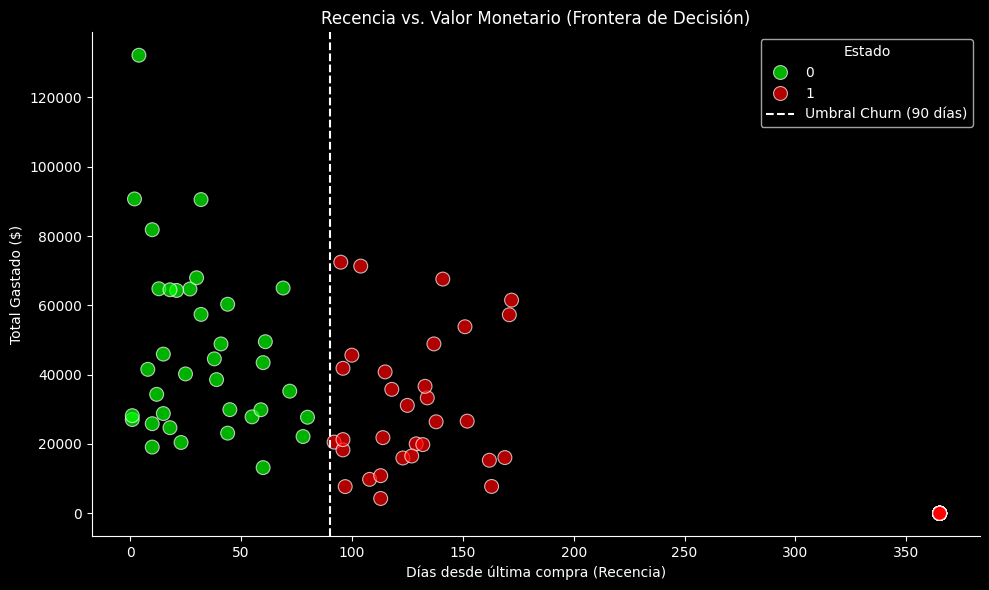

In [5]:
# Visualización Exploratoria
visualize_data(df_model)

### 💡 Interpretación del Gráfico de Dispersión (Recencia vs. Monetario)

Este gráfico nos permite visualizar visualmente la regla de negocio y la distribución de los clientes:

*   **Eje X (Recencia):** Días desde la última compra. Cuanto más a la derecha, más tiempo ha pasado sin comprar.
*   **Eje Y (Monetario):** Total gastado por el cliente.
*   **Línea Punteada Blanca:** Representa el **Umbral de Churn (90 días)**. 
    *   Los puntos a la **derecha** (color rojo) son clientes clasificados como **Churn** (Inactivos).
    *   Los puntos a la **izquierda** (color verde) son clientes **Activos**.
    *   **Nota Importante:** Verás una línea vertical de puntos rojos exactamente en el día 365. Estos son los **clientes inactivos** que recuperamos del archivo maestro y a los que asignamos manualmente una recencia de 1 año para incluirlos en el modelo.

**Insight:** Podemos observar claramente cómo la regla de los 90 días divide a la población. Además, vemos si los clientes que abandonan son de alto valor (puntos rojos altos en el eje Y) o de bajo valor.

## 4. Entrenamiento del Modelo

In [6]:
# 3. Entrenamiento
# NOTA: Excluimos 'recencia_dias' para evitar data leakage directo, 
# ya que el target se construyó con esta variable.
features = ['frecuencia_compras', 'monetario_total', 'antiguedad_dias', 'total_articulos', 'ticket_promedio']

model, X_test, y_test, y_pred, y_proba = train_evaluate_model(df_model, features)

🔍 Buscando mejores hiperparámetros...
🏆 Mejores parámetros: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.92      0.92      0.92        13

    accuracy                           0.90        20
   macro avg       0.89      0.89      0.89        20
weighted avg       0.90      0.90      0.90        20

AUC-ROC: 0.9890


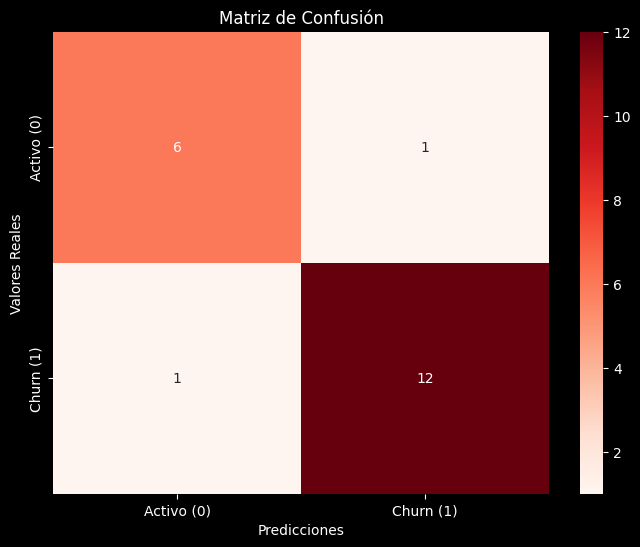

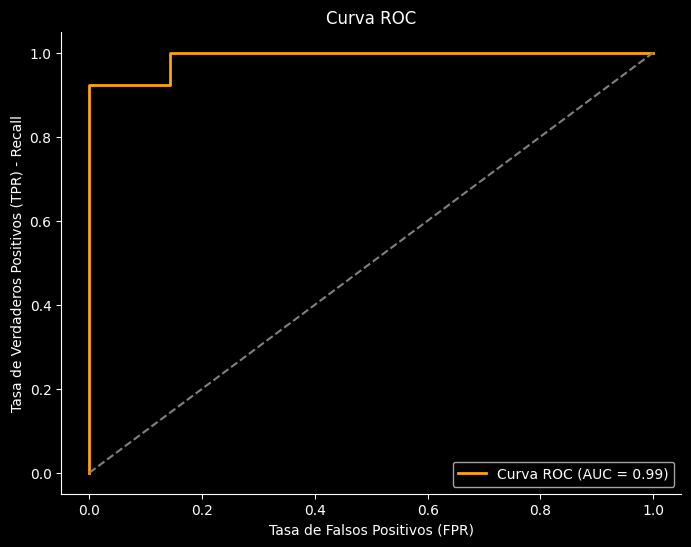

In [7]:
# Visualización de Performance
visualize_performance(y_test, y_pred, y_proba)

### 💡 Interpretación de la Evaluación del Modelo

**1. Matriz de Confusión:**
*   Muestra qué tan bien acertó el modelo en sus predicciones.
*   **Diagonal Principal (Tonos oscuros):** Son los aciertos (Verdaderos Negativos y Verdaderos Positivos). Queremos que los números altos estén aquí.
*   **Fuera de la Diagonal:** Son los errores. 
    *   *Falsos Negativos:* Clientes en Churn que el modelo dijo que eran Activos (¡Peligroso para el negocio!).
    *   *Falsos Positivos:* Clientes Activos que el modelo dijo que eran Churn (Costo de marketing innecesario).

**2. Curva ROC (Receiver Operating Characteristic):**
*   Muestra la capacidad del modelo para distinguir entre clases.
*   **AUC (Area Under Curve):** Un valor de **1.0** es perfecto; **0.5** es como lanzar una moneda.
*   Cuanto más se acerque la curva naranja a la esquina superior izquierda, mejor es el modelo.

## 5. Análisis de Importancia y Guardado


💾 Modelo guardado como 'churn_model.joblib' en la carpeta models/


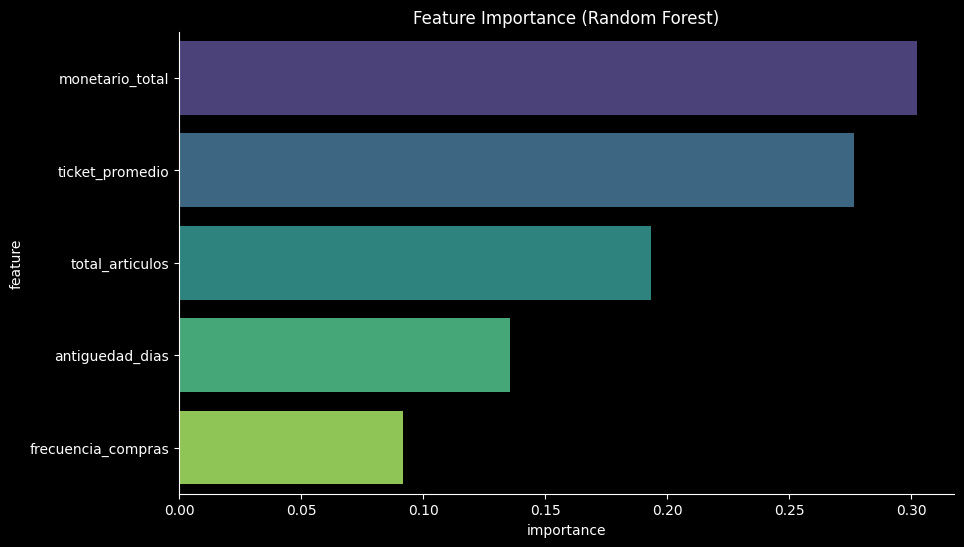

In [8]:
# 4. Guardar Modelo

# OPCIÓN 1: Ruta dinámica (más robusta, multiplataforma)
# Descomenta estas líneas si necesitas ejecutar el notebook desde diferentes ubicaciones
# notebook_dir = os.path.dirname(os.path.abspath('__file__'))
# model_path = os.path.join(notebook_dir, '..', 'models', 'churn_model.joblib')
# model_path = os.path.normpath(model_path)
# joblib.dump(model, model_path)
# print(f"💾 Modelo guardado como '{model_path}'")

# OPCIÓN 2: Ruta relativa simple (opción actual)
# Funciona cuando el notebook se ejecuta desde code/notebooks/
joblib.dump(model, '../models/churn_model.joblib')
print("\n💾 Modelo guardado como 'churn_model.joblib' en la carpeta models/")

# Visualización de Importancia de Características (del mejor modelo)
if hasattr(model.named_steps['classifier'], 'feature_importances_'):
    importances = model.named_steps['classifier'].feature_importances_
    feature_names = features
    
    feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feat_imp = feat_imp.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feat_imp, hue='feature', palette='viridis', legend=False)
    plt.title('Feature Importance (Random Forest)')
    plt.show()

### 💡 Interpretación de la Importancia de Características

Este gráfico nos dice **qué variables pesaron más** en la decisión del modelo:

*   Las barras más largas indican las variables más influyentes.
*   Si **'monetario_total'** o **'frecuencia_compras'** están arriba, significa que el comportamiento de gasto y visita es lo que mejor predice si un cliente se va a ir.
*   Esta información es vital para diseñar estrategias: si la frecuencia es clave, debemos crear programas de lealtad que incentiven visitas recurrentes.